# Exploratory Data Analysis

In [1]:
# Setup
!pip install -q datasets transformers wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [2]:
# Load tokenizer
from transformers import AutoTokenizer
mpnet = "sentence-transformers/all-mpnet-base-v2"
allmini = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(allmini)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [3]:
print(tokenizer.eos_token)
print(tokenizer.pad_token)

None
[PAD]


In [4]:
tokenizer.eos_token = "EOS"
tokenizer.pad_token = "UNK"
print(f"Loaded Tokenizer : {tokenizer}" if tokenizer else "Failed to load")

Loaded Tokenizer : BertTokenizerFast(name_or_path='sentence-transformers/all-MiniLM-L6-v2', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': 'EOS', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': 'UNK', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


In [5]:
from enum import Enum
from pathlib import Path
from datasets import load_dataset, load_from_disk
from dataclasses import dataclass, field

In [6]:
# # Load Dataser
# fingpt = load_dataset("FinGPT/fingpt-fiqa_qa")
# fingpt.save_to_disk("dataset")
# test = load_from_disk("/content/dataset/")

In [7]:
class Scope(Enum):
    TRAIN = "train"

@dataclass
class Sample:
    instruction: str
    input: str
    output: str

    def formatted(self):
        template = """
        {INSTRUCTION}
        {INPUT}
        {OUTPUT}
        """
        complete = template.format(
            INSTRUCTION=self.instruction,
            INPUT=self.input,
            OUTPUT=self.output
        )
        return complete

In [8]:
class DatasetGenerator:
    def __init__(self, file_path: Path, scope: Scope, sample: int=2000):
        self._scope = scope
        self.tokenizer = tokenizer
        self.sample = sample
        self.dataset = self._load_dataset(file_path)

    def size(self):
        return len(self.dataset)

    def _load_dataset(self, file_path: Path):
        try:
            dataset = load_dataset(file_path, split=self._scope.value)
            print("=" * 10 + " Info " + "=" * 10)
            print(f"Dataset load from HuggingFace : {file_path}")
            print(f"Loaded : {len(dataset)} samples.")
            return dataset

        except FileNotFoundError:
            print("Dataset Not Found")
            raise FileNotFoundError("Check File path from HuggingFace")
    def tokenize(self, tokenizer):
        """Iterates through the dataset prompts, tokenizes and saves a stores a sublist
        of tokens for each prompt."""

        formated_samples = list(map(lambda en: Sample(**en), self.dataset))
        tokenized_samples = []

        for sample in formated_samples:
            as_str = sample.formatted()
            tokenized = tokenizer(
                as_str
            )
            tokenized = tokenized["input_ids"]
            tokenized_samples.append(tokenized)
        return tokenized_samples

    def samples_gen(self):
        formatted_samples = list(map(lambda en: Sample(**en), self.dataset))
        for sample in formatted_samples:
            yield sample

In [10]:
# 1. Prerequisites
dataset_file = "fahmiaziz/fingpt"


# 2. Prepare dataset
dataset = DatasetGenerator(file_path=dataset_file, scope=Scope.TRAIN)
tokenized_samples = dataset.tokenize(tokenizer)

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

========== Info ==========
Dataset load from HuggingFace : fahmiaziz/fingpt
Loaded : 2000 samples.


Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


## EDA-01 Tokens Based
- Average Tokens Length
  - Check the average length in tokens of your fine-tuning prompts. Helps to identify the overall context-window you can aim for.
- Token Lengths Distribution
  - Visually inspect which context-window size covers all your fine-tuning dataset.
- Min/Max Token Distributions + (25-75) Percentiles
  - Verbose representation of tokens lengths of your fine-tuning dataset.

In [11]:
import numpy as np
token_mean = np.mean([len(x) for x in tokenized_samples])
print(f"Average Prompt Length : {token_mean} tokens")

Average Prompt Length : 405.137 tokens


Using arbitrary: MinTokenLimit = 256 toks.
Using arbitrary: MaxTokenLimit = 512 toks


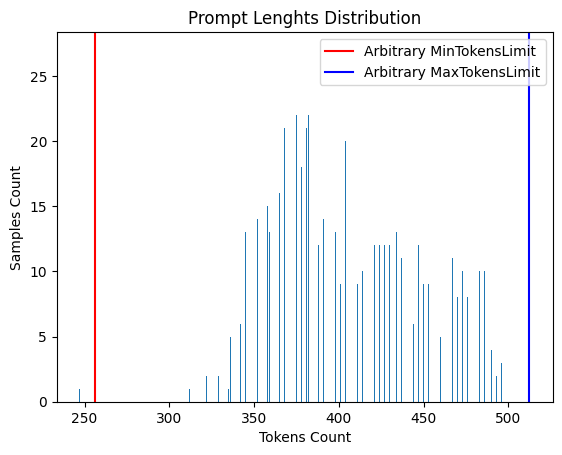

In [14]:
# Token Lengths Distribution
import matplotlib.pyplot as plt

lens = [len(x) for x in tokenized_samples]
min_toks_bar = 256
max_toks_bar = 512
plt.hist(lens, bins=len(tokenized_samples))
plt.title("Prompt Lenghts Distribution")
plt.xlabel("Tokens Count")
plt.ylabel("Samples Count")
print(f"Using arbitrary: MinTokenLimit = {min_toks_bar} toks.")
print(f"Using arbitrary: MaxTokenLimit = {max_toks_bar} toks")
plt.axvline(min_toks_bar, color="red", label="Arbitrary MinTokensLimit")
plt.axvline(max_toks_bar, color="blue", label="Arbitrary MaxTokensLimit")
plt.legend()
plt.show()

In [13]:
# Percentiles .25 .5 .75
import numpy as np
lens = [len(x) for x in tokenized_samples]
print(f"Minimum Prompt Lenght : {np.min(lens)} tokens")
print(f"Maximum Prompt Lenght : {np.max(lens)} tokens")

p25, p50, p75 = np.percentile(lens, [25, 50, 75])
print(f"25th percentile: {p25:.0f} tokens")
print(f"50th (median) percentile: {p50:.0f} tokens")
print(f"75th percentile: {p75:.0f} tokens")

Minimum Prompt Lenght : 247 tokens
Maximum Prompt Lenght : 513 tokens
25th percentile: 371 tokens
50th (median) percentile: 402 tokens
75th percentile: 436 tokens


## EDA-02 Prompt Coverage Based
- Prompt Coverage as a function of Tokens Length
  - Establishing a context-window size, inspect the prompts tokens distribution of the dataset that fits within the selected window.

Min selected ctx-window: 256 toks
Max selected ctx-window: 512 toks


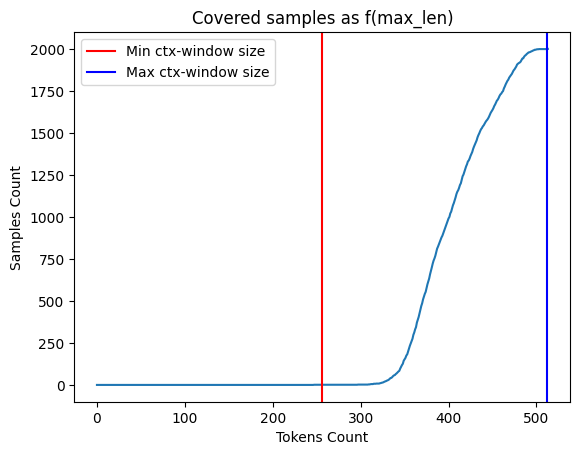

In [16]:
# Plot tokens distributions
plt.plot([len([l for l in lens if l <= m]) for m in range(max(lens) + 1)])
context_window_p1 = 256
context_window_p2 = 512
print(f"Min selected ctx-window: {context_window_p1} toks")
print(f"Max selected ctx-window: {context_window_p2} toks")
plt.title("Covered samples as f(max_len)")
plt.xlabel("Tokens Count")
plt.ylabel("Samples Count")
plt.axvline(x=context_window_p1, color="red", label="Min ctx-window size")
plt.axvline(x=context_window_p2, color="blue", label="Max ctx-window size")
plt.legend()
plt.show()

## EDA-03 Prompt lengths boxplot
- Median: This line shows the median value of token lengths in each interval. Inspect the central tendency.
- Box Length: A larger box suggests greater variability in prompt lengths within that interval.
- Out-bound lines: They represent the range of the data.
- Points outside the whiskers are outliers. Unusually long/short compared to the existing values within that interval.


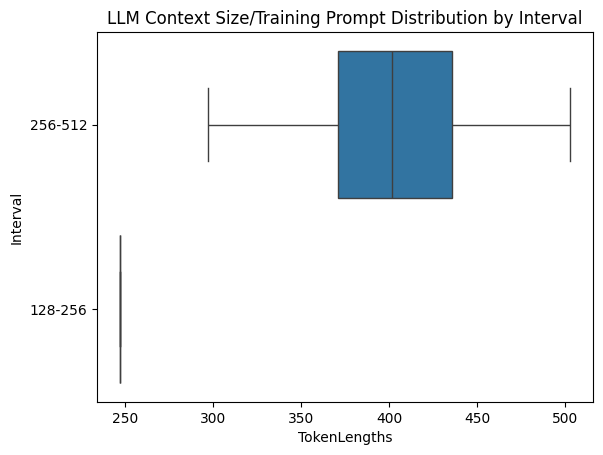

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


intervals = [(128, 256), (256, 512)]

data = []
for length in lens:
    for start, end in intervals:
        if start <= length < end:
            data.append({'TokenLengths': length, 'Interval': f'{start}-{end}'})
            break

df = pd.DataFrame(data)

sns.boxplot(x='TokenLengths', y='Interval', data=df)
plt.title('LLM Context Size/Training Prompt Distribution by Interval')
plt.show()


## EDA-04 WordCloud Analysis
- Visual representation of most representative words
- Helps in preventing bias towards a specific theme (overfit)
- Helps into processing/removing irrelevant frequent words
- Could serve as a basic quality check of your overall dataset vocabulary

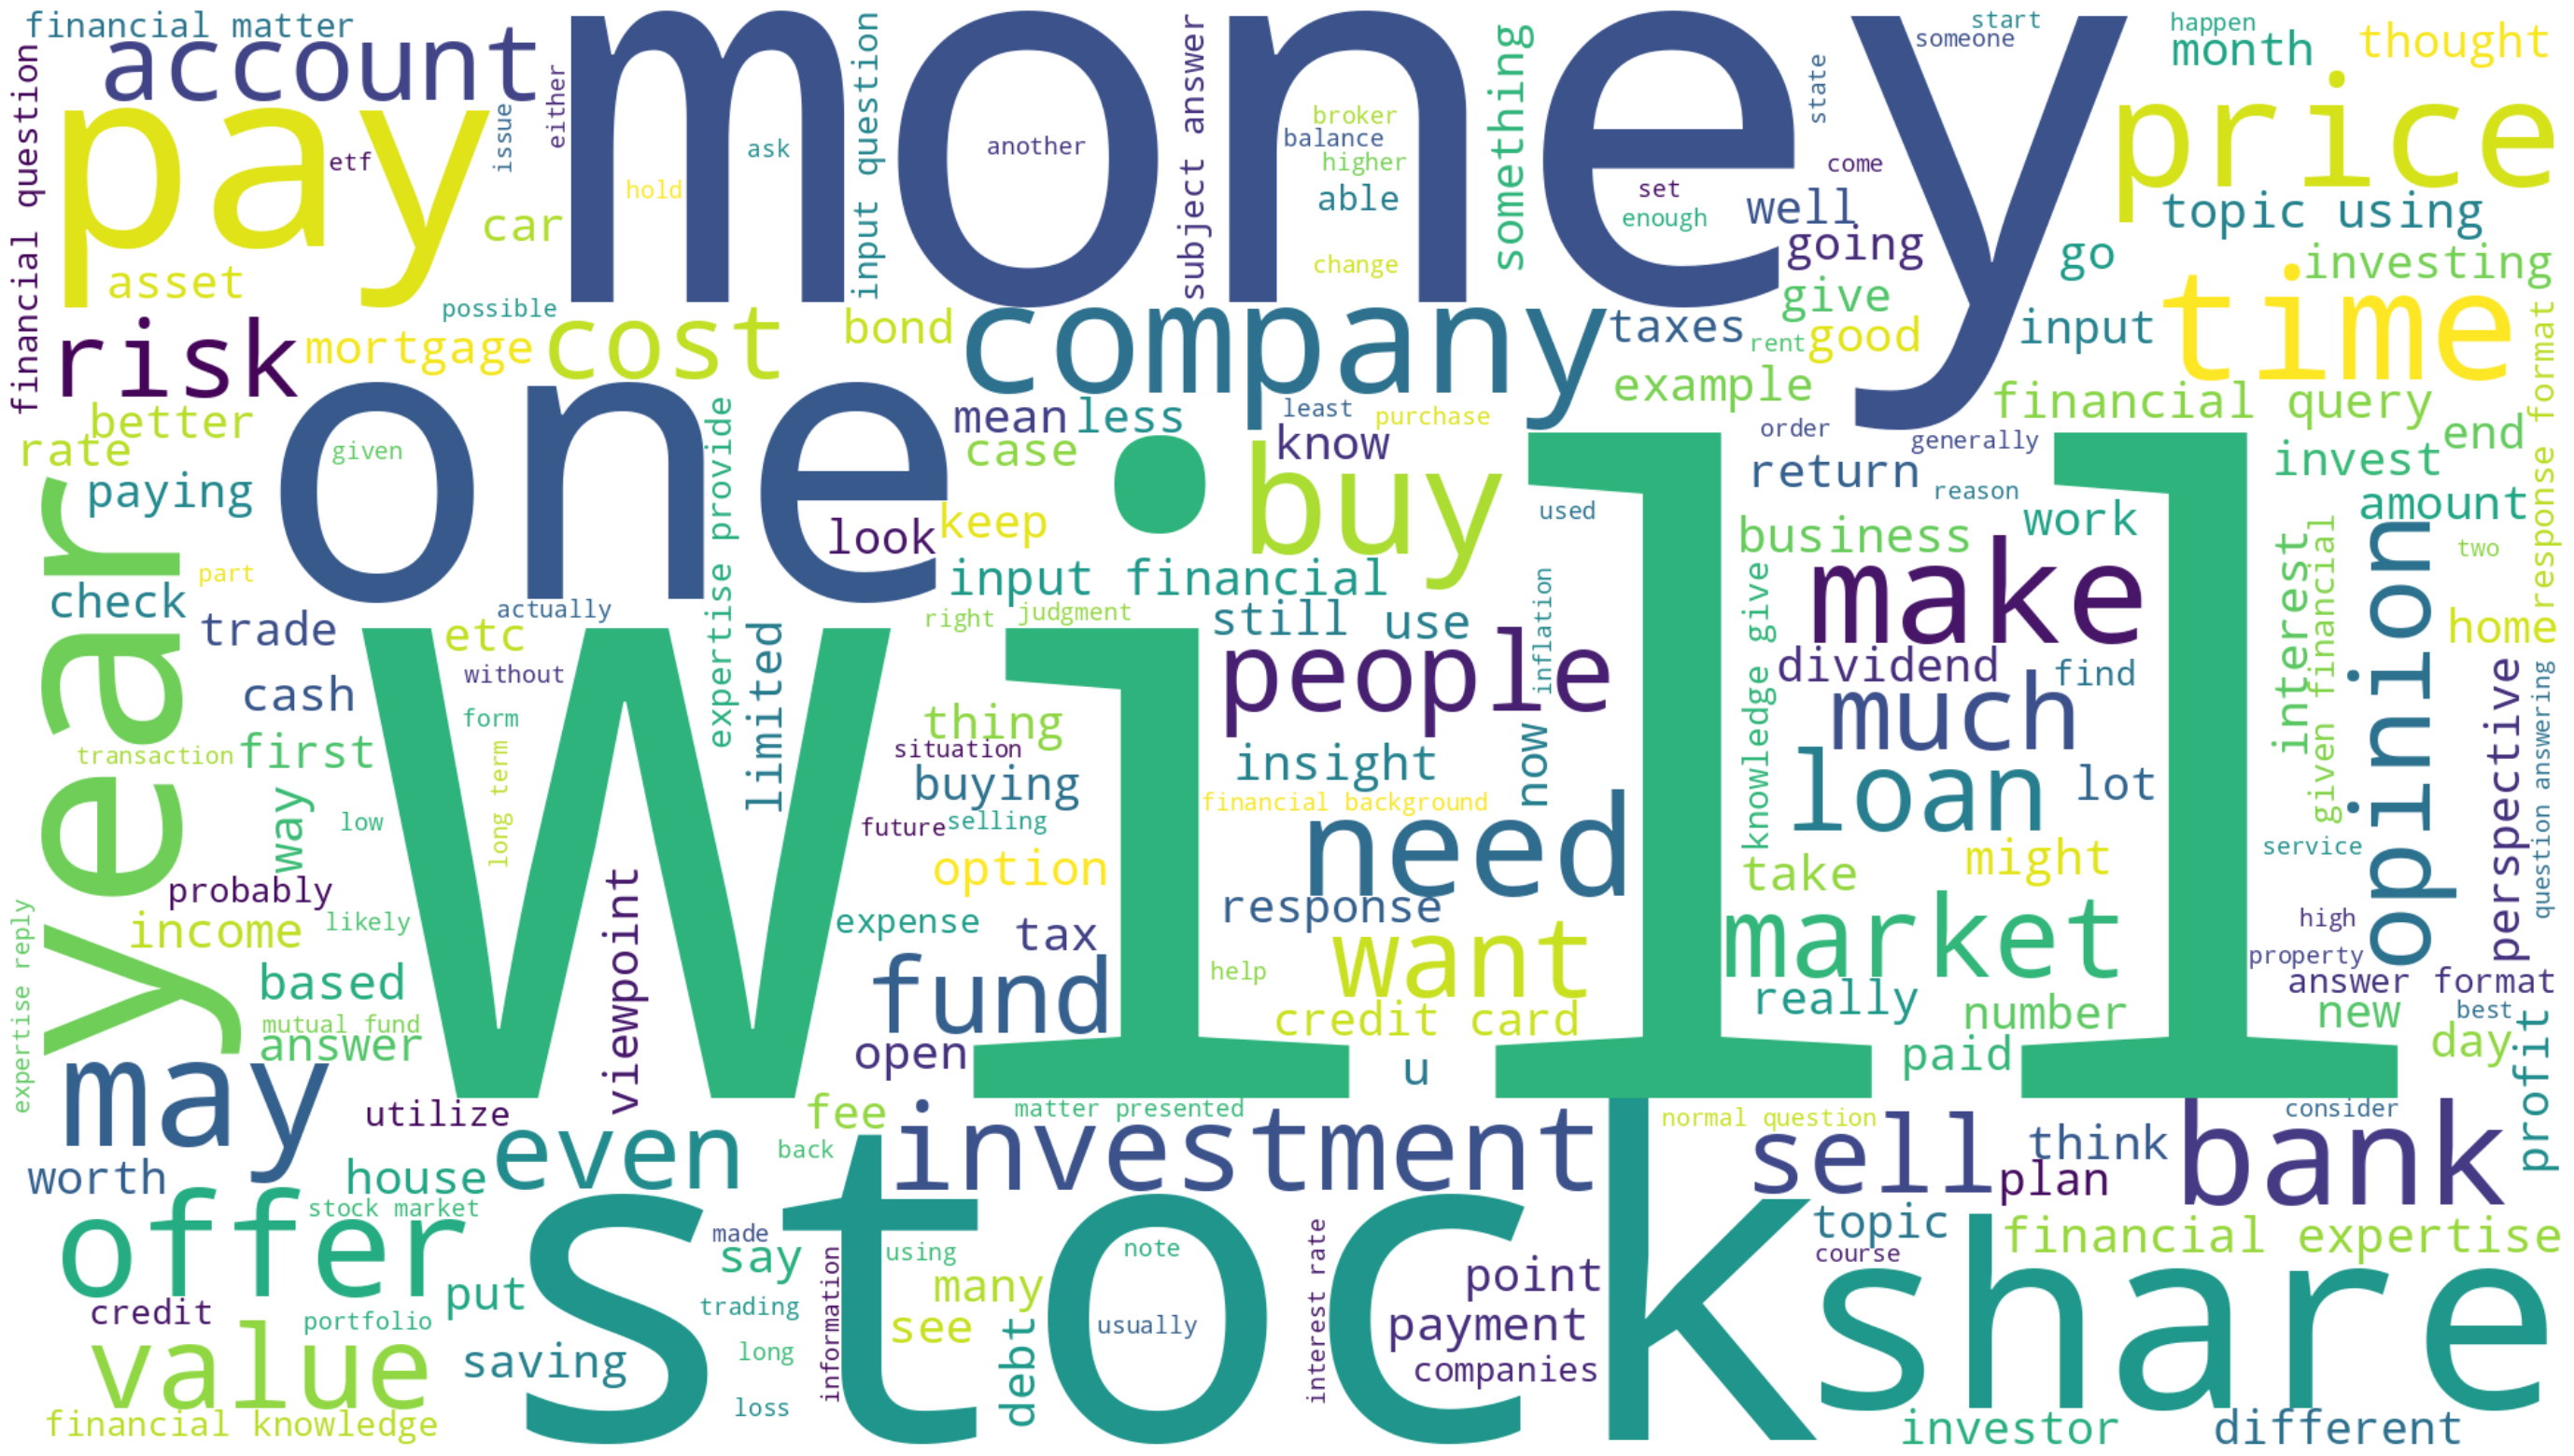

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ""
generator = dataset.samples_gen()
for sample in generator:
    text += sample.formatted()
text = text.lower().replace('.', '').replace(',', '')

wordcloud = WordCloud(width=1920, height=1080, background_color='white').generate(text)

plt.figure(figsize=(40,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()